In [1]:
#Data handling
import h5py
#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns


#Mathematical libraries
import numpy as np
import scipy.stats as stats
import bottleneck
import statsmodels.api as sm
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.sparse import csr_matrix
from scipy import sparse
import pickle
import subprocess
import itertools

In [449]:
def prec_recall (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial = df_trial.reset_index()
    #df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    #df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
    df_trial['PPV'] = df_trial['true_pos_cum'] / (df_trial['true_pos_cum'] + df_trial['true_neg_cum'] )
    df_trial['recall'] = df_trial['true_pos_cum']  / (df_trial['true_pos'].sum())
    #df_trial['recall'] = df_trial['recall'].round(1)
    #df_trial['f-score'] = (2 * df_trial['PPV'] * df_trial['recall']) / (df_trial['PPV'] + df_trial['recall'])
    #df_trial.iloc[df_trial['f-score'].idxmax()]
    return list(zip(df_trial['recall'].tolist(), df_trial['PPV'].tolist()))



def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
        
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()
    
def calc_auc_curve (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial['true_neg_tmp'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    df_trial['true_pos_tmp'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos_tmp'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg_tmp'].cumsum()
    #return dict(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))
    #df_trial['true_neg_cum'] = df_trial['true_neg_cum'].round(1)
    return list(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))

In [3]:
data = pd.read_csv('cath-b-newest-all.txt', sep=" ", header=None)
data.columns = ["pdb_chain_domain", "version", "cath", "residues"]
df = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/gene3dout.hdf5', 'nw') #this was the file written from api
df = pd.concat([df.drop(['metadata'], axis=1), df['metadata'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['evidences'], axis=1), df['evidences'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['source'], axis=1), df['source'].apply(pd.Series)], axis=1)
df = df.loc[df['type'] == 'PREDICTED_DOMAIN']
df_cath_prediction = df[df['resource'].isin(['pDomTHREADER'])]
df_cath_prediction['loc_length'] = [i[0]['fragments'][0]['end'] - i[0]['fragments'][0]['start'] + 1 for i in df_cath_prediction['locations']]
#df_cath_prediction = df[df['resource'].isin(['FUGUE (CATH-based)', 'Gene3D', 'pDomTHREADER'])]
del df_cath_prediction['length']
del df_cath_prediction['tooltipContent']
del df_cath_prediction['anno_id']
del df_cath_prediction['type']
del df_cath_prediction['code']
del df_cath_prediction['name']
del df_cath_prediction['url']
df_cath_prediction['confidence'] = df_cath_prediction['confidence'].astype('int')
df_cath_prediction = df_cath_prediction[(df_cath_prediction['confidence'] > 95) & (df_cath_prediction['loc_length'] > 80)]
merged_left = pd.merge(left=df_cath_prediction, right=data, how='left', left_on='id', right_on='pdb_chain_domain')
merged_left
merged_left.dropna(inplace=True)
idx = merged_left.groupby(['accession'])['loc_length'].transform(max) == merged_left['loc_length']
merged_left = merged_left[idx]
merged_left['pdb'] = merged_left['pdb_chain_domain'].str[:4] # removing extra characters in protein name
merged_left['chain'] = merged_left['pdb_chain_domain'].str[4:5]
merged_left['pdb_chain'] = merged_left['pdb'] + '_' + merged_left['chain']

/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
exp = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/filtered_exp.hdf5', 'nw') #this was the file written from api
subset_cols = list (set(exp.index) & set(merged_left.accession))
exp = exp.loc[subset_cols, subset_cols]

In [5]:
long_form = exp.unstack()
long_form.index.rename(['col_1', 'col_2'], inplace=True)
long_form = long_form.to_frame('exp').reset_index()
uni_list = merged_left['accession'].tolist()

In [6]:
uni_pdb = dict(zip(merged_left.accession,merged_left.pdb))

uni_pdbdomain = dict(zip(merged_left.accession,merged_left.pdb_chain_domain))

uni_pdb_chain =  dict(zip(merged_left.accession,merged_left.pdb_chain))

new=merged_left['cath'].str.split(".", n = 3, expand = True)  # expand the cath domains
merged_left['cat'] = new[0] + '.' + new[1] + '.' + new[2]
merged_left_uniq_domain = merged_left.drop_duplicates(subset=['pdb_chain_domain'])

domain_cath =  dict(zip(merged_left_uniq_domain.pdb_chain_domain,merged_left_uniq_domain.cat))

uni_id = list(set(list(exp.index.values)))
domain_uniq= [uni_pdbdomain[y] for y in uni_id]
index_list = list(itertools.combinations(domain_uniq,2))

#this is done to preserve the order of the list
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
index_list = f7(index_list)

In [7]:
result = []
for i in range(0,20):
    score_df = pd.read_hdf('/data/lohia/EGAD_analysis/egad_cath/dompair_tmscores_%s.h5' %i)
    result.append(score_df)
df_domain_pair_tm_score = pd.concat(result) 

In [8]:
id1 = df_domain_pair_tm_score["id1"].tolist()
id2 = df_domain_pair_tm_score["id2"].tolist()
tmscore = df_domain_pair_tm_score["tmscore"].tolist()

df_domain_pair_tm_score_rev = pd.DataFrame({"id1": id2, "id2": id1, "tmscore": tmscore })


df_domain_pair_tm_score_identity = pd.DataFrame({"id1": list(domain_uniq), "id2": list(domain_uniq), "tmscore": 1 })


df_domain_pair = pd.concat([df_domain_pair_tm_score, df_domain_pair_tm_score_rev, df_domain_pair_tm_score_identity], ignore_index=True)

In [9]:
df_domain_pair['pair'] = df_domain_pair['id1'] + '_' + df_domain_pair['id2']
domainpair_score =  dict(zip(df_domain_pair.pair,df_domain_pair.tmscore))

In [10]:
tm_score_domain = [ domainpair_score[uni_pdbdomain[uni_1] + '_' + uni_pdbdomain[uni_2]] for uni_1, uni_2 in zip(long_form['col_1'], long_form['col_2'])]

In [11]:
long_form["tm_score"] = tm_score_domain

In [12]:
prot_list_sp = np.array_split(long_form, 5675, axis=0)

In [772]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
m_l = []
for sim_thresh in [x*0.1 for x in [7,9]]:
    for i in range(0,5675):

        long_form_top = prot_list_sp[int(i)]
        long_form_top = long_form_top[long_form_top["tm_score"] >= 0.0]
        #long_form_top = long_form_top[long_form_top["tm_score"] < 1]

        #print (long_form_top)
        long_form_top = long_form_top[long_form_top['col_1'] != long_form_top['col_2']]
        try: 
           mp =  long_form_top['col_1'].values[0]
        except IndexError:
           mp = ''
        #print (long_form_top['col_1'].values[0])
        #long_form_top = long_form_top[long_form_top["tm_score"] <= 0.98]
        #long_form_top = long_form_top[long_form_top["exp"] >= 0.6]
        
        exp_median = long_form_top['exp'].median()
        exp_mean = long_form_top['exp'].mean()
        if exp_median >= 0.6:
            
            long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)            

            long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
            long_form_top = long_form_top.reset_index()
            #print ("here")
            #long_form_top = long_form_top.head(100)
            
            #rank(long_form_top["tm_score"].to_numpy())
            #rank(long_form_top['exp'].to_numpy())
            long_form_top["True_sim"] = [1 if score >= sim_thresh else 0 for score in long_form_top["tm_score"]]
            #long_form_top["True_sim"] = long_form_top["tm_score"] * 0
            #long_form_top["True_sim"][0:9] = long_form_top["True_sim"][0:9] + 1 
            #long_form_top["True_sim"][0:9] = (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
            #print (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
            #print (long_form_top["True_sim"])
            #the top ten macthes are considered TP
            #print (long_form_top)
            #rank_abs = lambda x: stats.rankdata(np.abs(x))
            #predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[long_form_top].values)
            
            long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
            long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
            #print (long_form_top["true_pos"].sum())
            #print (long_form_top["true_neg"].sum())
            long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
            #print ("here2")
            
            ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
            m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
            pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')

            tpd = pd.DataFrame(m_curve)
            if m_curve:
                tpd[0] =  tpd[0].astype(float).round(2)
                tpd = tpd.groupby([0]).mean()
                #print (tpd)
                #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                m_curve  = dict(zip(tpd.index, tpd[1]))
               #print (m_curve)
            else:
                m_curve  = {}
            tpd = pd.DataFrame(pr_curve)
            #print (pr_curve)
            if pr_curve:
                tpd[0] =  tpd[0].astype(float).round(2)
                tpd = tpd.groupby([0]).mean()
                #print (tpd)
                #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                pr_curve  = dict(zip(tpd.index, tpd[1]))
            else:
                pr_curve  = {}
                
            m_l.append((sim_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean))
        else:
            pass

In [782]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean'])

#df_scores = df_scores[df_scores['threshold']==0.8]

In [776]:
df_scores.dropna(inplace=True)
df_scores['threshold'] = df_scores['threshold'].round(2)

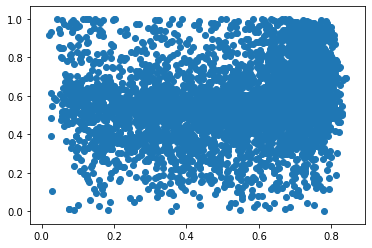

In [722]:
fig, axes = plt.subplots()
axes.scatter(df_scores['exp_median'] , df_scores['auc'] )
#axes.set_ylim([0,1])
plt.show()

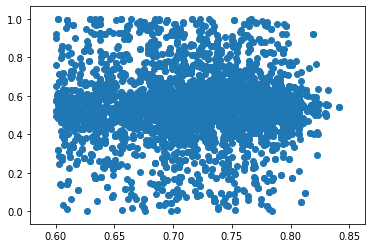

In [783]:
fig, axes = plt.subplots()
axes.scatter(df_scores['exp_median'] , df_scores['auc'] )
#axes.set_ylim([0,1])
plt.show()

In [705]:
df_scores_auc_7 = df_scores[df_scores['auc'] > 0.7]

In [731]:
df_scores

threshold       auc                                           pr_curve  \
0           0.9  0.150794             {0.0: 0.0, 1.0: 0.0005731990420446795}   
1           0.9  0.157694            {0.0: 0.0, 1.0: 0.00034657260011096696}   
2           0.9  0.590783  {0.0: 0.0, 0.02: 0.015200492868011006, 0.04: 0...   
6           0.9  0.862540  {0.0: 0.0, 0.33: 0.003396807997800376, 0.67: 0...   
7           0.9  0.854261  {0.0: 0.0, 0.5: 0.0019237152358109338, 1.0: 0....   
...         ...       ...                                                ...   
5667        0.9  0.542452  {0.0: 0.0, 0.14: 0.0011762955669217304, 0.29: ...   
5669        0.9  0.638484  {0.05: 0.75, 0.1: 0.6666666666666666, 0.14: 0....   
5670        0.9  0.443337  {0.0: 0.0, 0.5: 0.0010220634151321705, 1.0: 0....   
5671        0.9  0.542946  {0.0: 0.0, 0.12: 0.0038928602141491088, 0.25: ...   
5673        0.9  0.573745  {0.0: 0.0, 0.05: 0.027715601365883084, 0.09: 0...   

      true_pos  true_neg prot_name  exp_median  exp_mean       0.0      0.01  \
0          1.0    1890.0    P04792    0.724144  0.727504  0.000000  0.000000   
1          1.0    3139.0    Q99683    0.774887  0.769651  0.000000  0.000000   
2         48.0    2914.0    Q8ND07    0.754454  0.753955  0.000000  0.000000   
6          3.0    3441.0    Q7Z5W3    0.847037  0.823433  0.000000  0.000000   
7          2.0    3743.0    Q96BH1    0.859595  0.839774  0.000000  0.000000   
...        ...       ...       ...         ...       ...       ...       ...   
5667       7.0    3811.0    Q6PD62    0.897061  0.863241  0.000000  0.000000   
5669      21.0      49.0    Q8WXD9    0.628478  0.634794  0.047619       NaN   
5670       2.0    1756.0    A8MPX8    0.721285  0.726187  0.000000  0.000000   
5671       8.0    2573.0    Q16643    0.722742  0.729692  0.000000  0.000000   
5673      22.0    3779.0    Q15008    0.905901  0.867325  0.000000  0.046591   

      ...      0.91      0.92      0.93      0.94      0.95      0.96  \
0     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2     ...  0.895833  0.900000  0.916667  0.916667  0.916667  0.916667   
6     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
7     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
...   ...       ...       ...       ...       ...       ...       ...   
5667  ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5669  ...       NaN  0.952381       NaN  0.952381       NaN  0.976190   
5670  ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5671  ...  0.935185  1.000000  1.000000  1.000000  1.000000  1.000000   
5673  ...  0.909091  0.909091  0.909091  0.909091  0.909091  0.909091   

          0.97      0.98      0.99  1.0  
0     1.000000  1.000000  1.000000  1.0  
1     1.000000  1.000000  1.000000  1.0  
2     0.941532  0.966667  0.998611  1.0  
6     1.000000  1.000000  1.000000  1.0  
7     1.000000  1.000000  1.000000  1.0  
...        ...       ...       ...  ...  
5667  1.000000  1.000000  1.000000  1.0  
5669       NaN  1.000000       NaN  1.0  
5670  1.000000  1.000000  1.000000  1.0  
5671  1.000000  1.000000  1.000000  1.0  
5673  0.909091  0.925000  1.000000  1.0  

[3525 rows x 109 columns]

In [777]:
df_scores = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)

In [778]:
df_scores['auc'].mean()

0.5498361699315829

In [779]:
df_plot = df_scores.groupby(['threshold']).mean()

In [739]:
df_plot.T.reset_index()[4::]

threshold     index       0.9
4          exp_mean  0.769484
5                 0  0.023685
6              0.01  0.037423
7              0.02  0.059574
8              0.03  0.077353
..              ...       ...
101            0.96  0.967875
102            0.97  0.975630
103            0.98  0.984044
104            0.99  0.991708
105               1  0.996512

[102 rows x 2 columns]

In [330]:
#df_scores.drop(columns=['auc', 'plot', 'true_pos', 'true_neg', 'prot_name'], inplace=True)

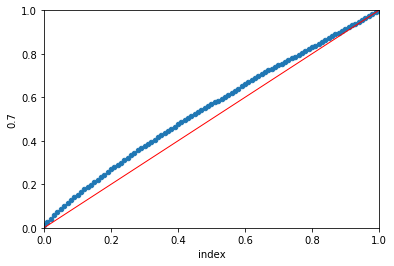

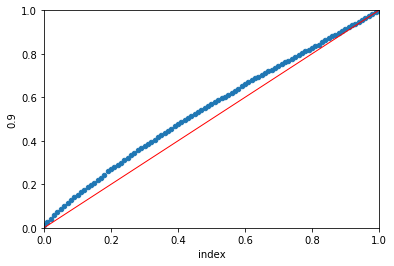

In [780]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[5::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

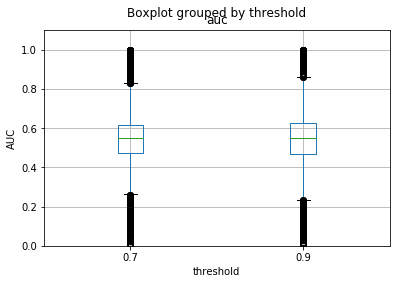

In [781]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='threshold', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()